Random Forest

In [ ]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X])

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stop criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < 2:
            leaf_value = self._most_common_label(y)
            return {"leaf": True, "value": leaf_value}

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)

        # Grow the children recursively
        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {"leaf": False, "feature": best_feature, "threshold": best_threshold, "left": left, "right": right}

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature, best_threshold = feature, threshold

        return best_feature, best_threshold

    def _information_gain(self, feature, y, threshold):
        # Split the data
        left_indices = feature < threshold
        right_indices = ~left_indices
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        # Calculate impurity
        parent_impurity = self._gini(y)
        n = len(y)
        n_left, n_right = len(y[left_indices]), len(y[right_indices])
        left_impurity = self._gini(y[left_indices])
        right_impurity = self._gini(y[right_indices])

        # Calculate information gain
        weighted_avg = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        return parent_impurity - weighted_avg

    def _gini(self, y):
        proportions = np.bincount(y) / len(y)
        return 1 - np.sum(proportions ** 2)

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def _predict_one(self, x, node):
        if node["leaf"]:
            return node["value"]
        if x[node["feature"]] < node["threshold"]:
            return self._predict_one(x, node["left"])
        return self._predict_one(x, node["right"])


In [ ]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]

        for _ in range(self.n_trees):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # Train a decision tree
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)


In [ ]:
# Load preprocessed CKD dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load the data
data = pd.read_csv("/content/drive/MyDrive/kidney_disease_preprocessed.csv")

# Encode the target variable 'classification' if necessary
# For example, replace 'ckd' with 1 and 'notckd' with 0
data["classification"] = data["classification"].replace({"ckd": 1, "notckd": 0})

# Split features and target
X = data.drop("classification", axis=1).values
y = data["classification"].values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for many models, including Random Forest)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the Random Forest class
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]

        for _ in range(self.n_trees):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # Train a decision tree
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)

# Define the DecisionTree class (as described earlier)

# Train and test Random Forest on CKD dataset
rf = RandomForest(n_trees=10, max_depth=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")


Random Forest Accuracy: 0.9875


In [ ]:
# New data point (make sure it has the same number of features as your training data)
# For example, a new data sample with features like 'age', 'bp', 'sg', etc.
new_data = np.array([[45, 120, 1.02, 2, 0, 0, 1, 1, 0, 110, 25, 0.8, 3.5, 140, 30, 20, 70, 4, 0, 1, 0, 1, 0, 0]])

# Scale the new data using the same scaler used during training
new_data_scaled = scaler.transform(new_data)

# Make prediction using the trained Random Forest model
prediction = rf.predict(new_data_scaled)

# Print the predicted class
if prediction == 1:
    print("The prediction is: Chronic Kidney Disease (CKD)")
else:
    print("The prediction is: No Chronic Kidney Disease (Not CKD)")

The prediction is: No Chronic Kidney Disease (Not CKD)


In [ ]:
new_data_batch = np.array([
    [45, 120, 1.02, 2, 0, 0, 1, 1, 0, 110, 25, 0.8, 3.5, 140, 30, 20, 70, 4, 0, 1, 0, 1, 0, 0],  # Example 1
    [55, 130, 1.03, 3, 1, 1, 0, 0, 1, 115, 22, 1.0, 3.6, 150, 28, 25, 75, 5, 1, 0, 1, 0, 1, 1]   # Example 2
])

new_data_batch_scaled = scaler.transform(new_data_batch)

# Make predictions for the new data batch
predictions_batch = rf.predict(new_data_batch_scaled)

# Print predictions for each new data point
for idx, pred in enumerate(predictions_batch):
  # Print the predicted class
  if predictions_batch[0] == 0:
      print("The prediction is: Chronic Kidney Disease (CKD)")
  elif predictions_batch[0] == 1:
      print("The prediction is: Borderline")
  elif predictions_batch[0] == 2:
      print("The prediction is: Not Chronic Kidney Disease (Not CKD)")
  else:
      print("Invalid prediction value.")

The prediction is: Chronic Kidney Disease (CKD)
The prediction is: Chronic Kidney Disease (CKD)


In [ ]:
# New data point indicating potential CKD
new_ckd_data = np.array([[60, 150, 1.05, 4, 1, 1, 1, 1, 1, 120, 40, 1.2, 3.0, 120, 22, 20, 80, 6, 1, 0, 1, 1, 0, 1]])

# Scale the new data using the same scaler used during training
new_ckd_data_scaled = scaler.transform(new_ckd_data)

# Make prediction using the trained Random Forest model
prediction_ckd = rf.predict(new_ckd_data_scaled)

# Print the predicted class
# Print the predicted class
if prediction_ckd[0] == 0:
    print("The prediction is: Chronic Kidney Disease (CKD)")
elif prediction_ckd[0] == 1:
    print("The prediction is: Borderline")
elif prediction_ckd[0] == 2:
    print("The prediction is: Not Chronic Kidney Disease (Not CKD)")
else:
    print("Invalid prediction value.")

The prediction is: Chronic Kidney Disease (CKD)


Confusion Matrix:
[[51  1]
 [ 0 28]]


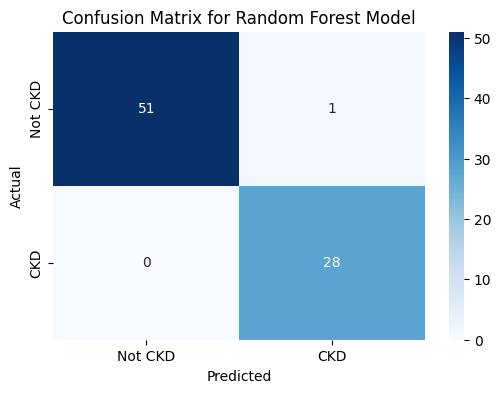

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not CKD", "CKD"], yticklabels=["Not CKD", "CKD"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

this confusion matrix is sus! it isnt supposed to be this goood. . . . . . :) something is wrong here please find out

In [ ]:
print(data['classification'].value_counts())

classification
0    248
2    150
1      2
Name: count, dtype: int64


In [ ]:
#confirmed CKD case
confirmed_ckd_case = [
    65,   # age (elderly)
    1.2,  # blood_pressure (mildly elevated)
    3.9,  # specific_gravity (low value indicates poor kidney function)
    4,    # albumin (high value is common in CKD)
    2,    # sugar (moderately high glucose levels)
    1,    # red_blood_cells (abnormal = 1, normal = 0)
    1,    # pus_cell (abnormal = 1, normal = 0)
    0,    # pus_cell_clumps (absent = 0, present = 1)
    1,    # bacteria (present = 1, absent = 0)
    5.8,  # blood_glucose_random (high value)
    8.5,  # blood_urea (elevated)
    2.6,  # serum_creatinine (high value)
    132,  # sodium (low sodium level common in CKD)
    3.8,  # potassium (elevated level common in CKD)
    30,   # hemoglobin (low level)
    40,   # packed_cell_volume (low level)
    3500, # white_blood_cell_count (low count indicates CKD)
    4.5,  # red_blood_cell_count (low count common in CKD)
    1,    # hypertension (yes = 1, no = 0)
    1,    # diabetes_mellitus (yes = 1, no = 0)
    1,    # coronary_artery_disease (yes = 1, no = 0)
    1,    # appetite (poor = 1, good = 0)
    1,    # pedal_edema (present = 1, absent = 0)
    0,    # anemia (absent = 0, present = 1)
    1     # classification (ckd = 1, notckd = 0)
]
